# The SIR and SEIR epidemiological models

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [4]:
import os
import sys
import glob
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Tue Mar 24 09:57:28 2020


In [5]:
import numpy as np
import pandas as pd
import matplotlib

In [6]:
fontsize=20
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': fontsize,
        }

plt.rcParams["font.size"     ] = fontsize


In [7]:
from scipy.integrate import odeint
import scipy.integrate as spi
from scipy.interpolate import interp1d


In [12]:
from dataclasses import dataclass, field

In [13]:
from c19.types import SIR, SEIR

In [28]:
import c19.basic_models as cbm
import c19.core_functions as cf
import c19.plotting as cplt
import c19.utils as ut

# SEIR with dead rate


- We expand the SEIR model to include de population of deceased. The equations are.

$$
\frac{dS}{dt} = - \frac{\beta}{N} S I \\
\frac{dE}{dt} = \frac{\beta}{N} I - \sigma E \\
\frac{dI}{dt} = \sigma E - \gamma I \\
\frac{dR}{dt} = (1 - \phi) \gamma I \\
\frac{dD}{dt} = \phi \gamma I -g D \\
M =g D \\
$$


In [52]:
N                = 1000
ND               = 400
TS               = 1.0
t_start          = 0.0 
t_end            = ND 
t_inc            = TS
t_range          = np.arange(t_start, t_end+t_inc, t_inc)
R0, Gamma, Sigma, Phi = 3, 1./7, 1./5., 1/7 
Beta             = Gamma * R0
I0, E0           = 1E-4, 1E-4
S0               = 1 - I0 - E0
Y0               = (S0, E0, I0)


In [53]:
RES = odeint(cbm.seir_deriv, Y0, t_range, args=(Beta, Gamma, Sigma))
S, E, I = RES.T
R = 1 - S - E - I
seirE = SEIR(N = N, S=S, I=I, E=E, R=R, beta=Beta, R0=R0, gamma=Gamma, sigma = Sigma, t= t_range)

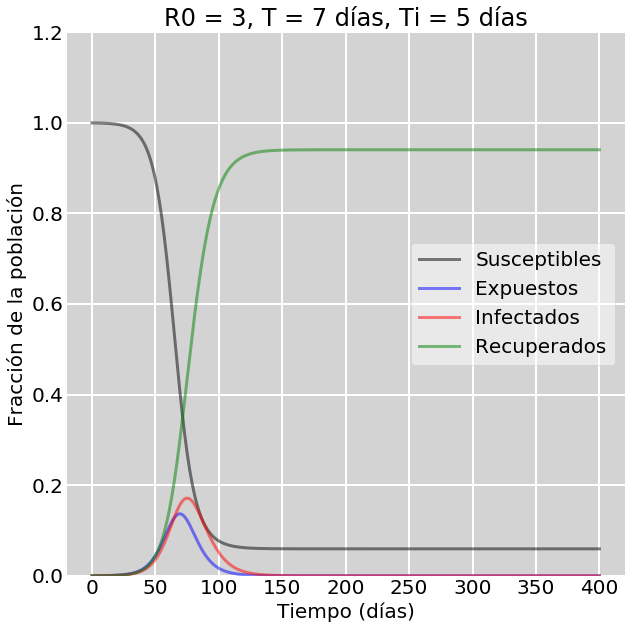

In [54]:
cplt.plot_seir(seirE, "R0 = 3, T = 7 días, Ti = 5 días")

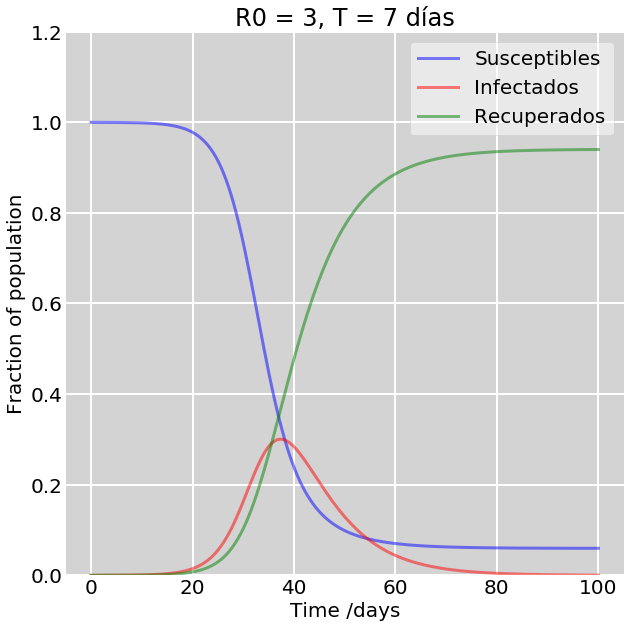

In [55]:
cplt.plot_sir(sirExample, "R0 = 3, T = 7 días")

## No mitigation

In [56]:

R0, Gamma, Sigma = 3, 1./7, 1./5. 
Beta             = Gamma * R0

In [57]:
M = cbm.mitigation_function(t_range, ts = [(0, 400)], ms=[1])

In [58]:
RES = odeint(cbm.seir_deriv_time, Y0, t_range, args=(M, Beta, Gamma, Sigma))

In [59]:
S, E, I = RES.T
R = 1 - S - E - I
seirNoMit = SEIR(N = N, S=S, I=I, E=E, R=R, beta=Beta, R0=R0, gamma=Gamma, sigma = Sigma, t= t_range)

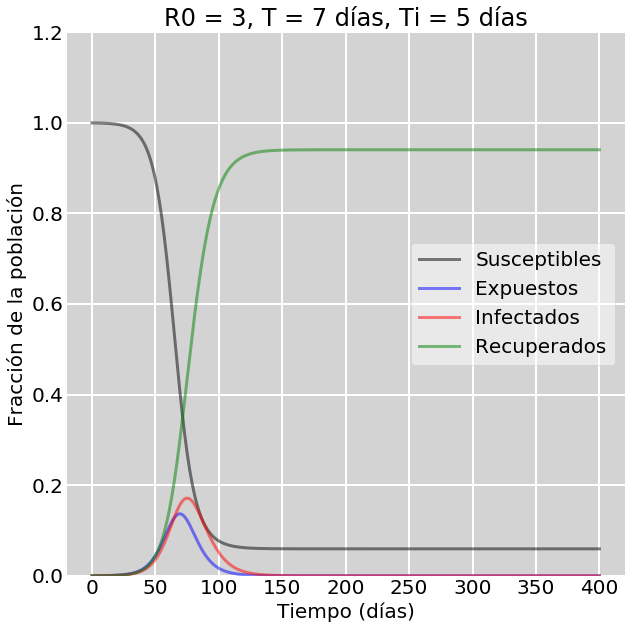

In [60]:
cplt.plot_seir(seirNoMit, "R0 = 3, T = 7 días, Ti = 5 días")

In [61]:
N                = 1000
ND               = 400
TS               = 1.0
t_start          = 0.0 
t_end            = ND 
t_inc            = TS
t_range          = np.arange(t_start, t_end+t_inc, t_inc)
R0, Gamma, Sigma = 3, 1./7, 1./5. 
Beta             = Gamma * R0
I0, E0           = 1E-4, 1E-4
S0               = 1 - I0 - E0
Y0               = (S0, E0, I0)


In [45]:
def compute_seir(deriv_seir, Y0, Beta, Gamma, Sigma, t_range, ts = [(0, 400)], ms=[0.8]):
    def deriv_seir(y, t, beta, gamma, sigma):
        """Prepare differential equations for SEIR """
        S, E, I = y
        dSdt = -beta * M(t) * S * I 
        dEdt = beta * M(t) * S * I - sigma * E
        dIdt = sigma * E - gamma * I
        return dSdt, dEdt, dIdt
    
    C         = mitigation(t_range, ts, ms)
    M         = interp1d(t_range, C, bounds_error=False, fill_value="extrapolate")
    RES       = odeint(deriv_seir, Y0, t_range, args=(Beta, Gamma, Sigma))
    S, E, I   = RES.T
    R         = 1 - S - E - I
    seir      = SEIR(N = N, S=S, I=I, E=E, R=R, beta=Beta, R0=R0, gamma=Gamma, sigma = Sigma, t= t_range)
    return seir
    

## Early mitigation: soft (80%), hard (60%), xhard (40%)

### soft

In [65]:
seirEMits = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, ts = [(0, 400)], ms=[0.8])

###  hard

In [67]:
seirEMith = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, ts = [(0, 400)], ms=[0.6])

### xhard

In [68]:
seirEMitx = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, ts = [(0, 400)], ms=[0.4])

## Late mitigation

### soft

In [69]:
seirLMits = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range,
                         ts = [(0, 20), (20,400)], ms=[1, 0.8])

### hard

In [73]:
seirLMith = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range,
                         ts = [(0, 20), (20,400)], ms=[1, 0.6])

### very hard

In [71]:
seirLMitx = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range,
                         ts = [(0, 20), (20,400)], ms=[1, 0.4])

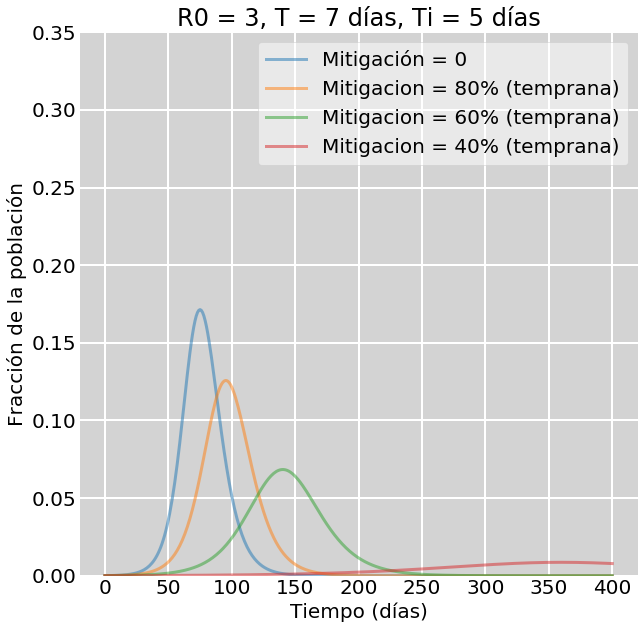

In [72]:
cplt.plot_Is([seirNoMit, seirEMits, seirEMith, seirEMitx], Ls = ['Mitigación = 0', 
                                                            'Mitigacion = 80% (temprana)', 
                                                            'Mitigacion = 60% (temprana)',
                                                            'Mitigacion = 40% (temprana)'], 
        T = "R0 = 3, T = 7 días, Ti = 5 días", 
        figsize=(10,10), facecolor='LightGrey')

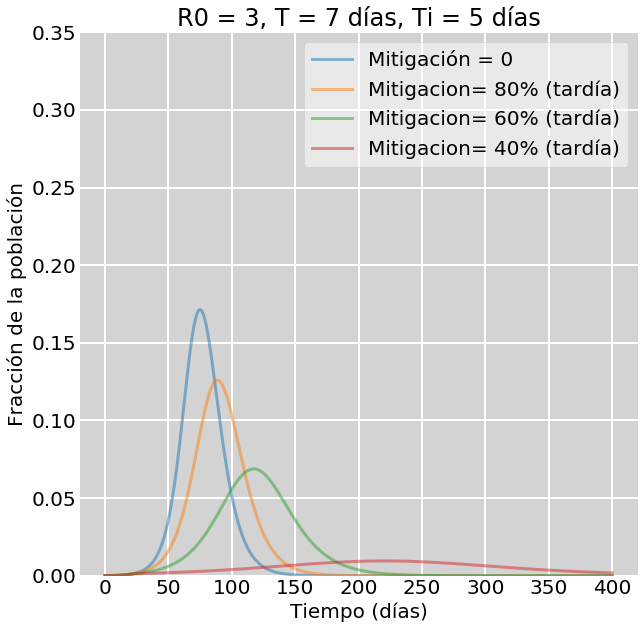

In [75]:
cplt.plot_Is([seirNoMit, seirLMits, seirLMith, seirLMitx], Ls = ['Mitigación = 0', 
                                                 'Mitigacion= 80% (tardía)', 
                                                 'Mitigacion= 60% (tardía)',
                                                 'Mitigacion= 40% (tardía)'], 
        T = "R0 = 3, T = 7 días, Ti = 5 días", 
        figsize=(10,10), facecolor='LightGrey')

## Early vs late

In [76]:
N                = 1000
ND               = 200
TS               = 1.0
t_start          = 0.0 
t_end            = ND 
t_inc            = TS
t_range          = np.arange(t_start, t_end+t_inc, t_inc)
R0, Gamma, Sigma = 3, 1./7, 1./5. 
Beta             = Gamma * R0
I0, E0           = 1E-4, 1E-4
S0               = 1 - I0 - E0
Y0               = (S0, E0, I0)

In [77]:
seirNoMit = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, ts = [(0, 200)], ms=[1.0])
seirEMits = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, ts = [(0, 200)], ms=[0.8])
seirLMits = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, 
                             ts = [(0, 20), (20,200)], ms=[1, 0.8])

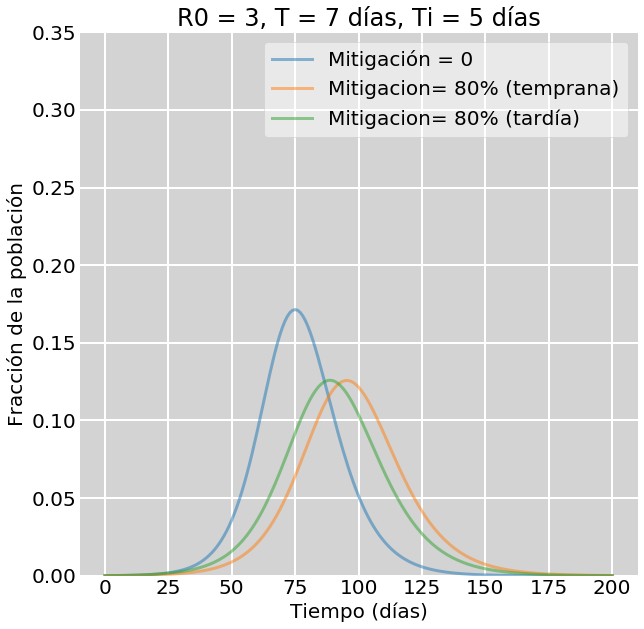

In [79]:
cplt.plot_Is([seirNoMit, seirEMits, seirLMits], Ls = ['Mitigación = 0', 
                                                 'Mitigacion= 80% (temprana)', 
                                                 'Mitigacion= 80% (tardía)',
                                                 ], 
        T = "R0 = 3, T = 7 días, Ti = 5 días", 
        figsize=(10,10), facecolor='LightGrey')

In [80]:
seirEMith = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, ts = [(0, 200)], ms=[0.6])
                            
seirLMith = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, 
                             ts = [(0, 20), (20,200)], ms=[1, 0.6])

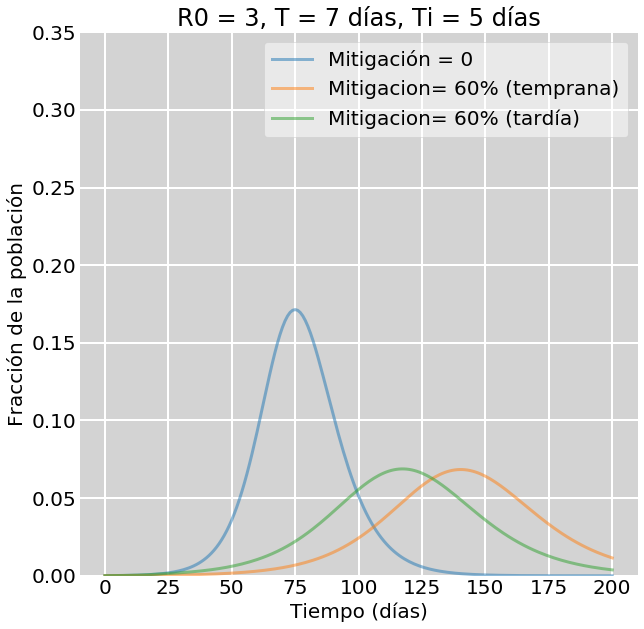

In [81]:
cplt.plot_Is([seirNoMit, seirEMith, seirLMith], Ls = ['Mitigación = 0', 
                                                 'Mitigacion= 60% (temprana)', 
                                                 'Mitigacion= 60% (tardía)',
                                                 ], 
        T = "R0 = 3, T = 7 días, Ti = 5 días", 
        figsize=(10,10), facecolor='LightGrey')

In [82]:
N                = 1000
ND               = 200
TS               = 1.0
t_start          = 0.0 
t_end            = ND 
t_inc            = TS
t_range          = np.arange(t_start, t_end+t_inc, t_inc)
R0, Gamma, Sigma = 3, 1./7, 1./5. 
Beta             = Gamma * R0
I0, E0           = 1E-4, 1E-4
S0               = 1 - I0 - E0
Y0               = (S0, E0, I0)

In [83]:
seirI = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, 
                         ts = [(0, 7), (8,15), (15, 200)], ms=[0.8, 0.6, 0.4])

In [84]:
seirR = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, 
                         ts = [(0, 15), (15, 200)], ms=[1,  0.4])

In [85]:
seirNoMit = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, ts = [(0, 200)], ms=[1.0])

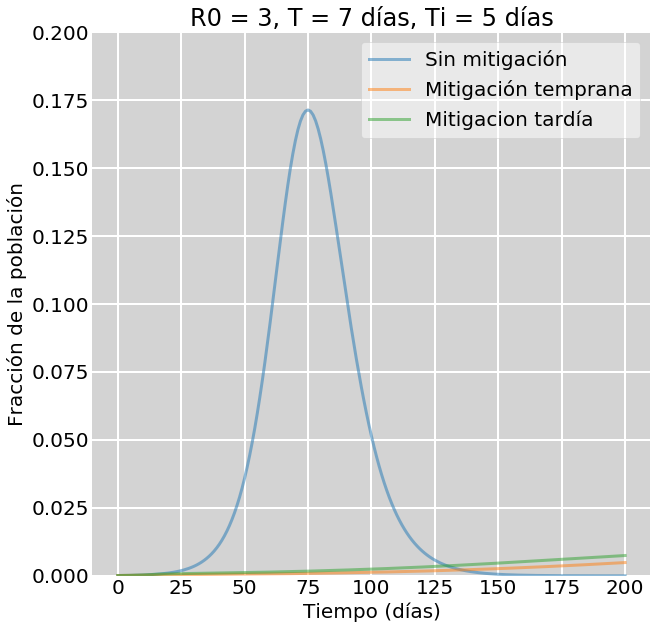

In [86]:
cplt.plot_Is([seirNoMit, seirI, seirR], Ls = ['Sin mitigación', 
                                         'Mitigación temprana', 
                                         'Mitigacion tardía',
                                                 ], 
        T = "R0 = 3, T = 7 días, Ti = 5 días", ylim=0.2,
        figsize=(10,10), facecolor='LightGrey')

In [101]:
N                = 1000
ND               = 400
TS               = 1.0
t_start          = 0.0 
t_end            = ND 
t_inc            = TS
t_range          = np.arange(t_start, t_end+t_inc, t_inc)
R0, Gamma, Sigma = 3, 1./7, 1./5. 
Beta             = Gamma * R0
I0, E0           = 1E-4, 1E-4
S0               = 1 - I0 - E0
Y0               = (S0, E0, I0)

In [102]:
seirI = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, 
                         ts = [(0, 7), (8,15), (15, 400)], ms=[0.8, 0.6, 0.4])

In [103]:
seirR = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, 
                         ts = [(0, 15), (15, 400)], ms=[1,  0.4])

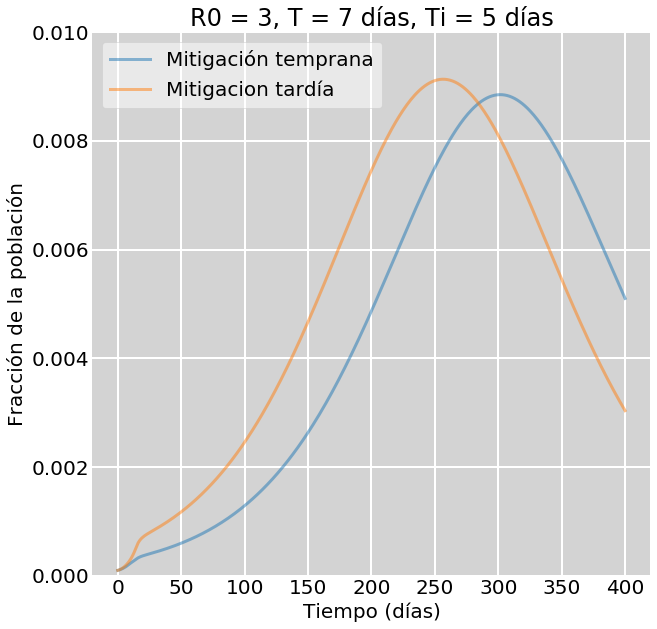

In [104]:
cplt.plot_Is([seirI, seirR], Ls = ['Mitigación temprana', 
                              'Mitigacion tardía',
                                                 ], 
        T = "R0 = 3, T = 7 días, Ti = 5 días", ylim= 0.01, 
        figsize=(10,10), facecolor='LightGrey')

In [91]:
N                = 1000
ND               = 40
TS               = 1.0
t_start          = 0.0 
t_end            = ND 
t_inc            = TS
t_range          = np.arange(t_start, t_end+t_inc, t_inc)
R0, Gamma, Sigma = 3, 1./7, 1./5. 
Beta             = Gamma * R0
I0, E0           = 1E-4, 1E-4
S0               = 1 - I0 - E0
Y0               = (S0, E0, I0)

In [92]:
seirNoMit = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range,  ts = [(0, ND)], ms=[1.0])

In [93]:
seirMit80 = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range,  ts = [(0, ND)], ms=[0.8])

In [95]:
seirMit60 = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, ts = [(0, ND)], ms=[0.6])

In [96]:
seirMit40 = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range,  ts = [(0, ND)], ms=[0.4])

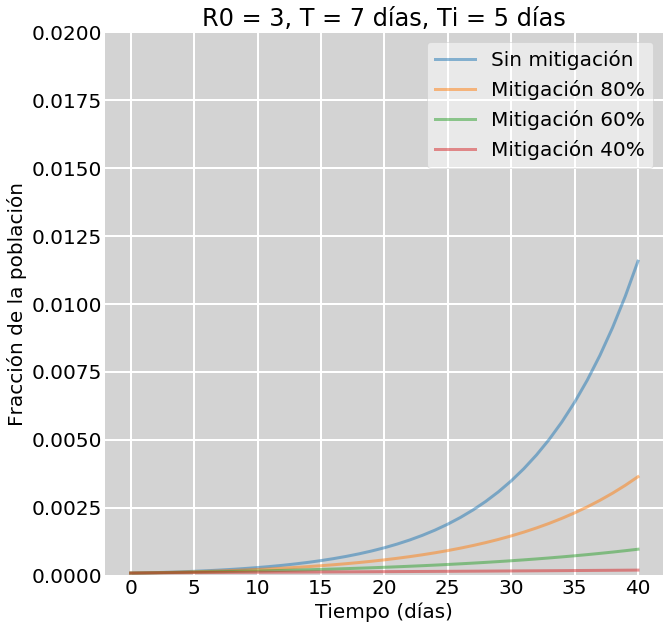

In [97]:
cplt.plot_Is([seirNoMit, seirMit80, seirMit60, seirMit40], Ls = ['Sin mitigación',
                                                            'Mitigación 80%',
                                                            'Mitigación 60%',
                                                            'Mitigación 40%'], 
        T = "R0 = 3, T = 7 días, Ti = 5 días", ylim= 0.02, 
        figsize=(10,10), facecolor='LightGrey')

## SIR and the beds

In [108]:
N                = 1000
ND               = 200
TS               = 1.0
t_start          = 0.0 
t_end            = ND 
t_inc            = TS
t_range          = np.arange(t_start, t_end+t_inc, t_inc)
R0, Gamma, Sigma = 3, 1./7, 1./5. 
Beta             = Gamma * R0
I0, E0           = 1E-4, 1E-4
S0               = 1 - I0 - E0
Y0               = (S0, E0, I0)

In [116]:
seirR = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, 
                         ts = [(0, 15), (15, ND)], ms=[1,  0.6])

In [117]:
IC, RC = ut.get_I_and_R_CAA(dca, seirR.N, seirR.I, seirR.R, norm=False)
Iur06 = ut.uci_cases(IC, f_uci = 0.05)

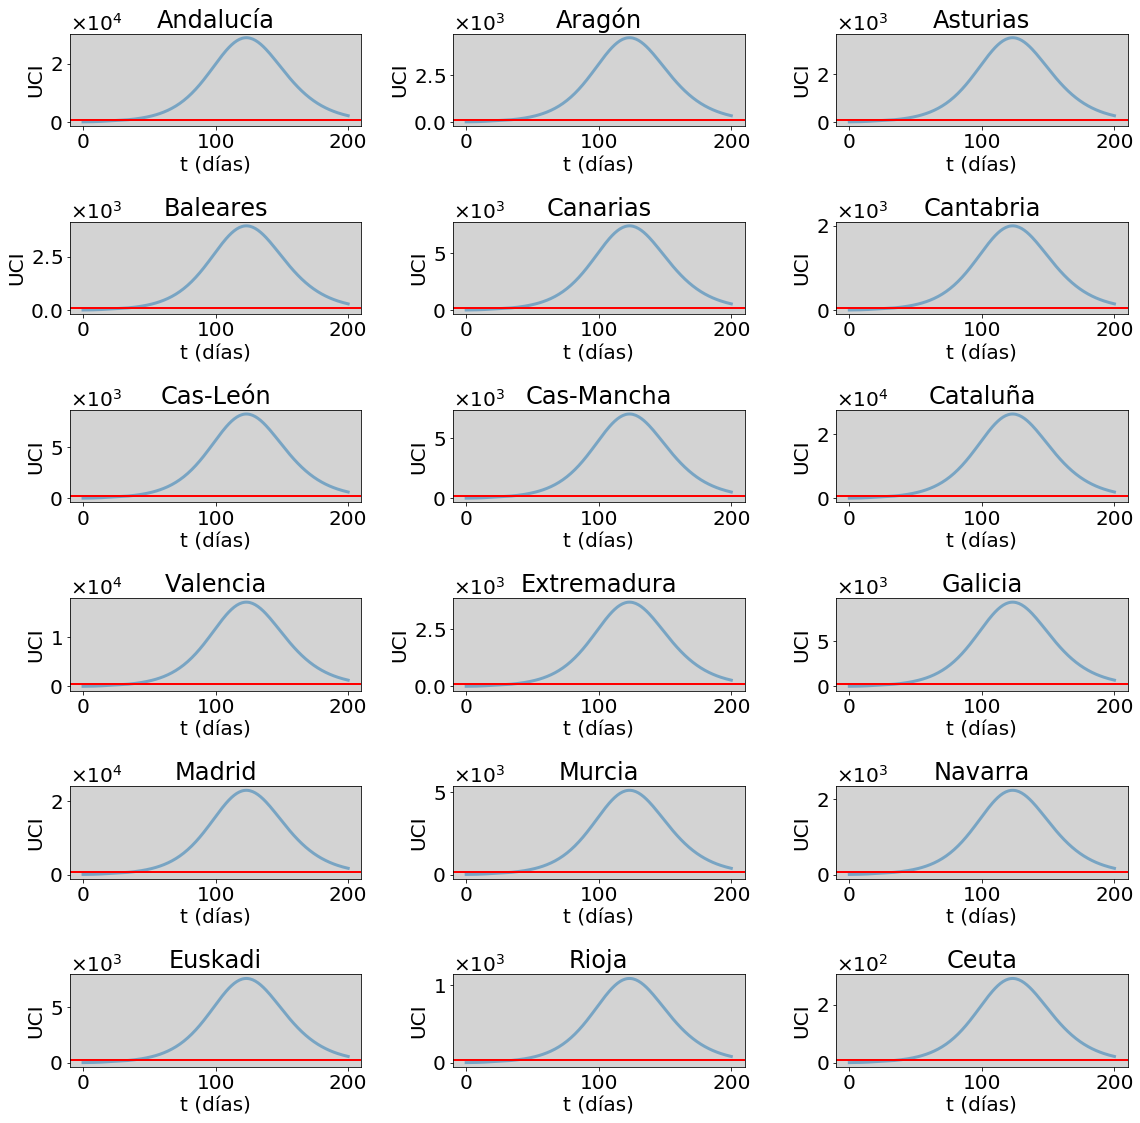

In [118]:
cplt.plot_ICAA(dca, ub, 
          t_range, Iur06, figsize=(16,16), facecolor='LightGrey')

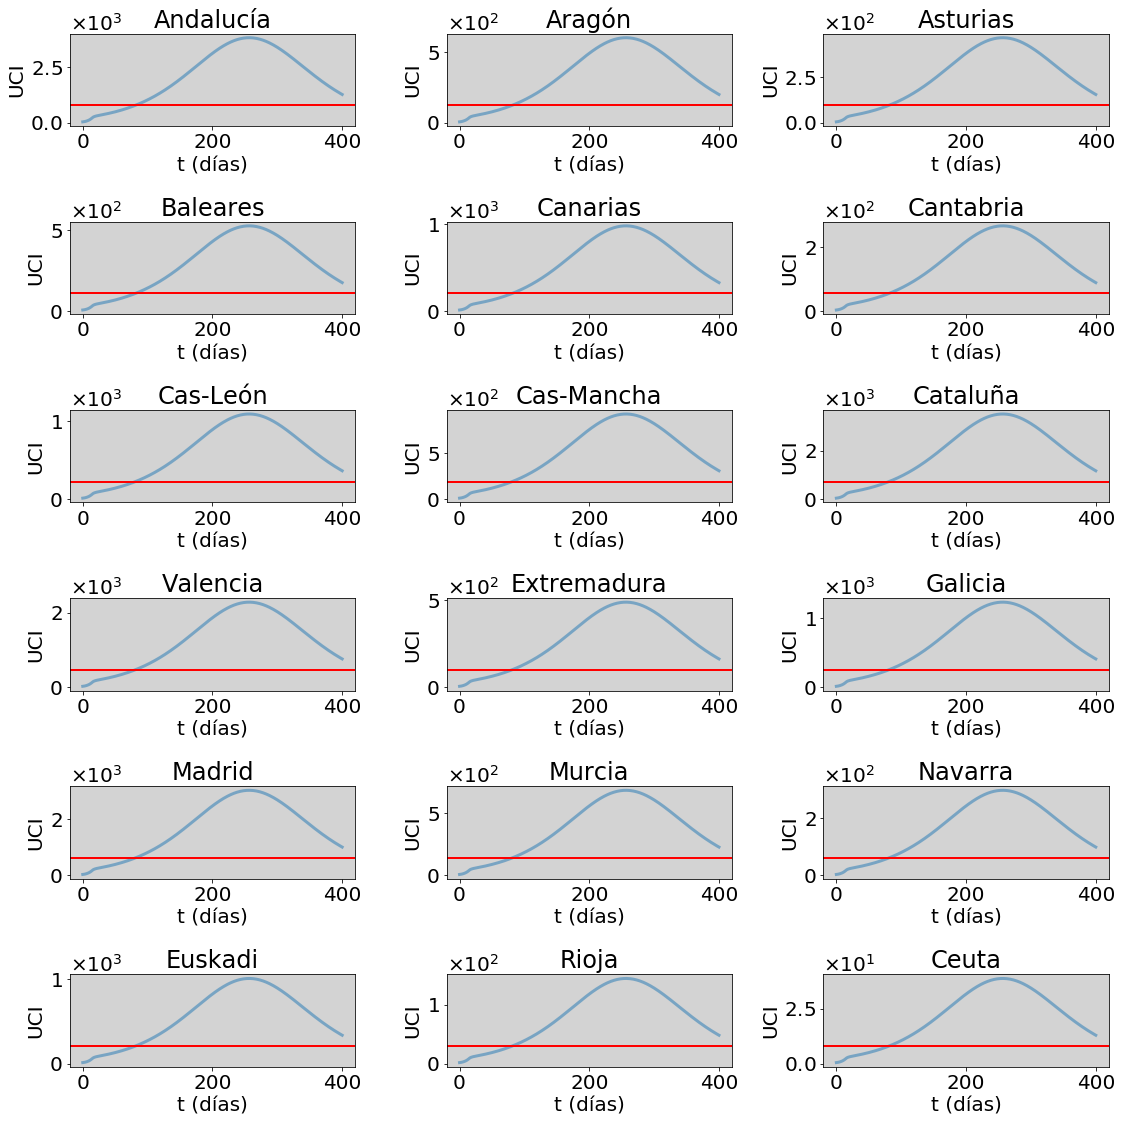

In [120]:
N                = 1000
ND               = 400
TS               = 1.0
t_start          = 0.0 
t_end            = ND 
t_inc            = TS
t_range          = np.arange(t_start, t_end+t_inc, t_inc)
R0, Gamma, Sigma = 3, 1./7, 1./5. 
Beta             = Gamma * R0
I0, E0           = 1E-4, 1E-4
S0               = 1 - I0 - E0
Y0               = (S0, E0, I0)

seirR = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, 
                         ts = [(0, 15), (15, ND)], ms=[1,  0.4])
IC, RC = ut.get_I_and_R_CAA(dca, seirR.N, seirR.I, seirR.R, norm=False)
Iur04 = ut.uci_cases(IC, f_uci = 0.05)
cplt.plot_ICAA(dca, ub, 
          t_range, Iur04, figsize=(16,16), facecolor='LightGrey')

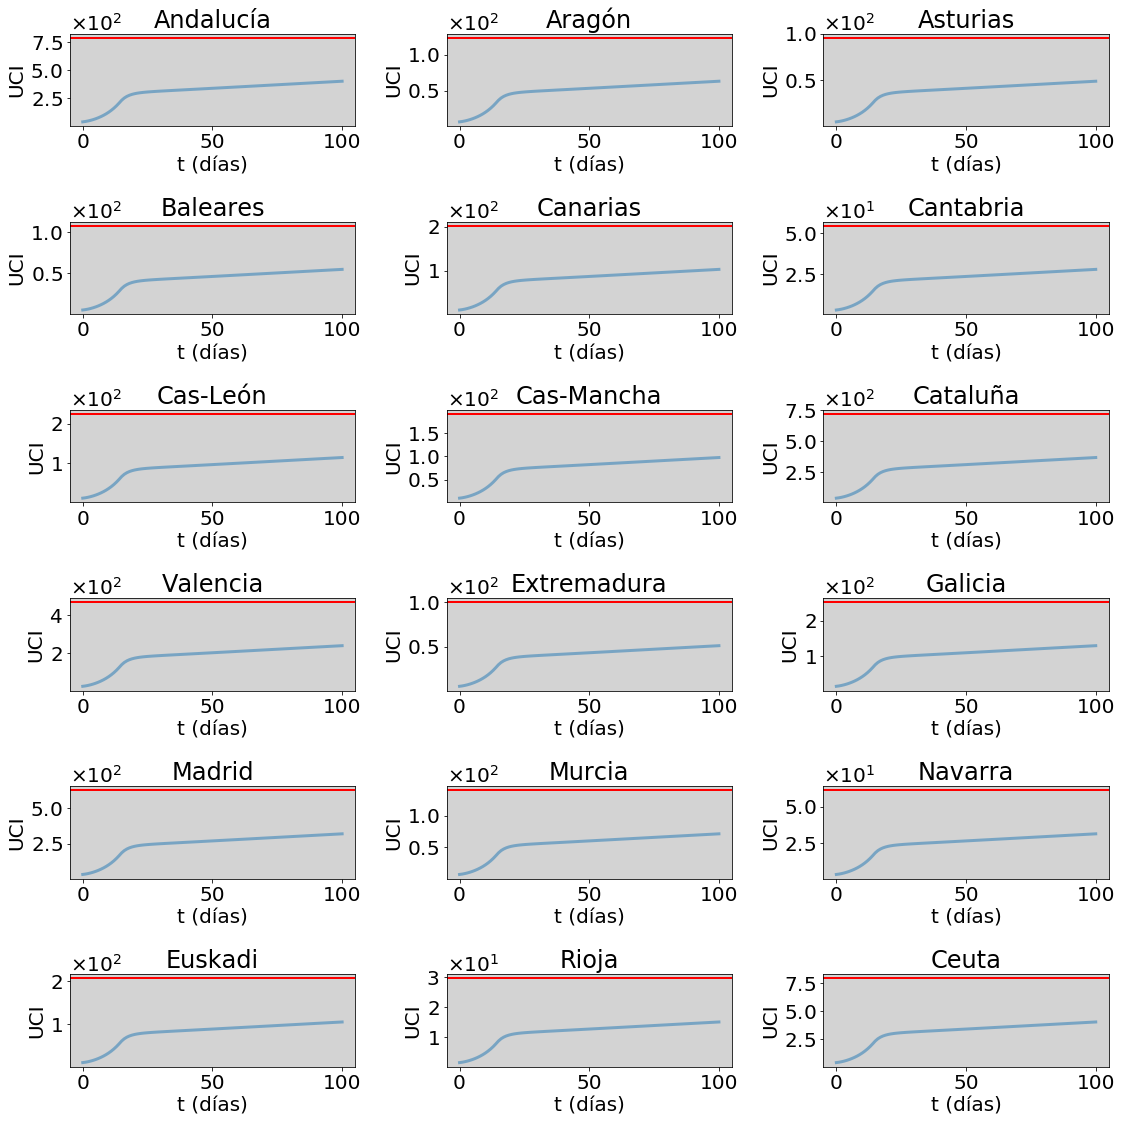

In [126]:
N                = 1000
ND               = 100
TS               = 1.0
t_start          = 0.0 
t_end            = ND 
t_inc            = TS
t_range          = np.arange(t_start, t_end+t_inc, t_inc)
R0, Gamma, Sigma = 3, 1./7, 1./5. 
Beta             = Gamma * R0
I0, E0           = 1E-4, 1E-4
S0               = 1 - I0 - E0
Y0               = (S0, E0, I0)

seirR = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, 
                         ts = [(0, 15), (15, ND)], ms=[1,  0.35])
IC, RC = ut.get_I_and_R_CAA(dca, seirR.N, seirR.I, seirR.R, norm=False)
Iur04 = ut.uci_cases(IC, f_uci = 0.05)
cplt.plot_ICAA(dca, ub, 
          t_range, Iur04, figsize=(16,16), facecolor='LightGrey')

In [138]:
3434 /47610

0.07212770426381013

In [131]:
0.58 * 17.85

10.353

In [135]:
17.85 / 13.5

1.3222222222222224

In [136]:
5476 / 59138

0.09259697656329263

In [137]:
281 / 5683

0.049445715291219425

In [139]:
1720 / 28572

0.060198796024079515

In [141]:
7.2 / 1.38

5.217391304347827

In [143]:
1/47

0.02127659574468085

In [145]:
123000 + 55000

178000